# Stock Valuation

This project aims to create a portfolio of stocks to buy. The priority is not to pick winning stocks, but to avoid picking losing stocks. I will aim to do this by assessing the value, growth, income and momentum of the companies in the US and UK stock market, and make a portfolio of these companies. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import requests
from IPython.display import display, clear_output
import time

## Company Information

This code is a template for use later on when more company information is required to assess the value of a stock.

In [2]:
# Example stock symbol
stock_symbol = 'AAPL'

# Create a Ticker object
ticker = yf.Ticker(stock_symbol)

# Get stock information
info = ticker.info

# Access specific metrics
pe_ratio = info.get('trailingPE', None)  # P/E ratio
forward_pe = info.get('forwardPE', None)  # Forward P/E ratio
peg_ratio = info.get('pegRatio', None)  # PEG ratio
price_to_book = info.get('priceToBook', None)  # Price/Book ratio
enterprise_to_revenue = info.get('enterpriseToRevenue', None)  # Enterprise Value/Revenue
enterprise_to_ebitda = info.get('enterpriseToEbitda', None)  # Enterprise Value/EBITDA

# Cash flow data is not directly available through the `info` attribute. 
# You need to use `cashflow` for the cash flow statement:
cash_flow_statement = ticker.cashflow

# Print the metrics
print(f"Stock: {stock_symbol}")
print(f"P/E Ratio: {pe_ratio}")
print(f"Forward P/E Ratio: {forward_pe}")
print(f"PEG Ratio: {peg_ratio}")
print(f"Price to Book Ratio: {price_to_book}")
print(f"Enterprise to Revenue: {enterprise_to_revenue}")
print(f"Enterprise to EBITDA: {enterprise_to_ebitda}")
print("\nCash Flow Statement (Annual):")
print(cash_flow_statement)

# Note: The cash flow statement provided here is annual by default. 
# You can get quarterly data by passing `quarterly=True` to `cashflow`.

Stock: AAPL
P/E Ratio: 26.342148
Forward P/E Ratio: 23.72269
PEG Ratio: 2.4
Price to Book Ratio: 35.339035
Enterprise to Revenue: 6.872
Enterprise to EBITDA: 20.371

Cash Flow Statement (Annual):
                                                    2023-09-30  \
Free Cash Flow                                   99584000000.0   
Repurchase Of Capital Stock                     -77550000000.0   
Repayment Of Debt                               -11151000000.0   
Issuance Of Debt                                  5228000000.0   
Issuance Of Capital Stock                                  NaN   
Capital Expenditure                             -10959000000.0   
Interest Paid Supplemental Data                   3803000000.0   
Income Tax Paid Supplemental Data                18679000000.0   
End Cash Position                                30737000000.0   
Beginning Cash Position                          24977000000.0   
Changes In Cash                                   5760000000.0   
Financing Ca

***

# Value Analysis

### Information Technology Sector

In [3]:
df = pd.read_csv('us_equities_filtered.csv')

df.columns

Index(['symbol', 'name', 'exchange', 'assetType', 'ipoDate', 'delistingDate',
       'status', 'sector'],
      dtype='object')

In [4]:
import numpy as np

def fetch_metrics(tickers):
    unique_tickers = list(set(tickers))
    metrics = {
        'symbol': [],
        'Market Cap': [],
        'Trailing P/E': [],
        'P/B Ratio': [],
        'Trailing EPS': [],
        'Forward P/E': [],
        'Forward EPS': [],
        'Dividend Yield %': [],
        'Beta': []
    }
    for ticker in unique_tickers:
        info = yf.Ticker(ticker).info
        metrics['symbol'].append(ticker)
        metrics['Market Cap'].append(float(info.get('marketCap', np.nan)))
        metrics['Trailing P/E'].append(float(info.get('trailingPE', np.nan)))
        metrics['P/B Ratio'].append(float(info.get('priceToBook', np.nan)))
        metrics['Trailing EPS'].append(float(info.get('trailingEps', np.nan)))
        metrics['Forward P/E'].append(float(info.get('forwardPE', np.nan)))
        metrics['Forward EPS'].append(float(info.get('forwardEps', np.nan)))
        metrics['Dividend Yield %'].append(float(info.get('dividendYield', np.nan)) * 100 if info.get('dividendYield') is not None else np.nan)
        metrics['Beta'].append(float(info.get('beta', np.nan)))
    return pd.DataFrame(metrics)


def graham_valuation(stock_metrics):
    """Determines if a stock meets Benjamin Graham's criteria for investment."""
    valuation_status = {}
    for index, row in stock_metrics.iterrows():
        meets_criteria = True
        # Check Graham's criteria
        if row['Trailing P/E'] >= 15 or row['Trailing P/E'] * row['P/B Ratio'] >= 22.5:
            meets_criteria = False
        #if row['Current_Ratio'] < 2 or row['Debt_to_Equity'] >= 1:
        #    meets_criteria = False
        # EPS Growth and Dividend Yield can be considered based on availability and specific criteria
        
        valuation_status[row.name] = "Undervalued" if meets_criteria else "Not Undervalued"
    
    return valuation_status

def calculate_benchmarks(df):
    """Calculates benchmarks (median) for a DataFrame of financial metrics."""
    # Select only numeric columns for the median calculation
    numeric_df = df.select_dtypes(include=[np.number])
    return numeric_df.median().to_dict()

def compare_stock_to_benchmarks(stock_metrics, sp500_benchmarks, sector_benchmarks):
    """Compares a single stock's metrics to S&P 500 and sector benchmarks."""
    comparison = {}
    for metric in stock_metrics.index:
        comparison[metric] = {
            'Stock': stock_metrics[metric],
            'S&P 500 Median': sp500_benchmarks.get(metric, np.nan),
            'Sector Median': sector_benchmarks.get(metric, np.nan),
        }
    return comparison

In [5]:
def sector_valuation_status(value, metric, sector_benchmarks):
    """Determines valuation status of a stock based on sector medians for specific metrics."""
    # Define a list of metrics to evaluate
    metrics_to_evaluate = ['Trailing P/E', 'Forward P/E', 'P/B Ratio']
    
    # Check if the metric is one of the specified metrics for comparison
    if metric in sector_benchmarks and metric in metrics_to_evaluate:
        median = sector_benchmarks[metric]
        if value < median * 0.8:
            return 'Undervalued'
        elif value > median * 1.2:
            return 'Overvalued'
        else:
            return 'Fair Value'
    return 'N/A'  # Return 'N/A' for metrics not specified for evaluation

In [6]:
def graham_valuation_status(stock_metrics):
    """Evaluates if a stock meets Benjamin Graham's investment criteria with transition ranges."""
    status = {}

    # Attempt to convert to float, use inf if conversion fails
    try:
        pe_ratio = float(stock_metrics.get('Trailing P/E', float('inf')))
    except ValueError:
        pe_ratio = float('inf')

    try:
        pb_ratio = float(stock_metrics.get('P/B Ratio', float('inf')))
    except ValueError:
        pb_ratio = float('inf')

    # Evaluate P/E Ratio
    if pe_ratio < 15:
        status['Trailing P/E'] = 'Undervalued'
    elif 15 <= pe_ratio <= 20:
        status['Trailing P/E'] = 'Fair Value'
    else:
        status['Trailing P/E'] = 'Overvalued'

    # Evaluate P/B Ratio
    if pb_ratio < 1.5:
        status['P/B Ratio'] = 'Undervalued'
    elif 1.5 <= pb_ratio <= 2:
        status['P/B Ratio'] = 'Fair Value'
    else:
        status['P/B Ratio'] = 'Overvalued'

    # Combined P/E * P/B criterion, introducing a range for transition
    combined_value = pe_ratio * pb_ratio
    if combined_value < 22.5:
        status['Combined P/E x P/B'] = 'Undervalued'
    elif 22.5 <= combined_value <= 27:
        status['Combined P/E x P/B'] = 'Fair Value'
    else:
        status['Combined P/E x P/B'] = 'Overvalued'

    return status

In [7]:
def plot_table_colored(df):
    # Adjust the figure size here (width, height) to make the table bigger
    fig, ax = plt.subplots(figsize=(20, len(df) * 0.5))  # Adding +2 for a bit more space
    ax.axis('tight')
    ax.axis('off')
    
    # Use a larger font size for readability
    plt.rcParams.update({'font.size': 10})
    
    table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.1 for _ in df.columns])  # Adjust column widths as necessary
    
    # Apply coloring based on valuation status
    for i, col in enumerate(df.columns):
        for j, _ in enumerate(df.index):
            cell_text = table[(j+1, i)].get_text().get_text()
            if "Graham Status" in col:
                # Use one color scheme for Graham-based valuation
                if "Undervalued" in cell_text:
                    table[(j+1, i)].set_facecolor('green')  # Light blue
                elif "Overvalued" in cell_text:
                    table[(j+1, i)].set_facecolor('red')  # Light coral
                elif "Fair Value" in cell_text:
                    table[(j+1, i)].set_facecolor('orange')  # Light green
            elif "Sector Status" in col:
                # Use a different color scheme for sector-based valuation
                if "Undervalued" in cell_text:
                    table[(j+1, i)].set_facecolor('#006400')  # Dark green
                    table[(j+1, i)].set_text_props(color='w')
                elif "Overvalued" in cell_text:
                    table[(j+1, i)].set_facecolor('#8b0000')  # Dark red
                    table[(j+1, i)].set_text_props(color='w')
                elif "Fair Value" in cell_text:
                    table[(j+1, i)].set_facecolor('#808080')  # Grey
                    table[(j+1, i)].set_text_props(color='w')
            else:
                # Neutral color for non-valued cells
                table[(j+1, i)].set_facecolor('#f5f5f5')
    
    plt.tight_layout()
    plt.show()

In [8]:
# Extract unique sectors from the 'GICS Sector' column
unique_sectors = df['sector'].unique()

# Convert the array of unique sectors to a list
sector_list = unique_sectors.tolist()

# Print the list of sectors
print(sector_list)

['Healthcare', 'Basic Materials', 'Consumer Defensive', 'Financial Services', 'Industrials', 'Technology', 'Consumer Cyclical', 'Real Estate', 'Energy', 'Communication Services', 'Utilities']


In [9]:
from IPython.display import display, clear_output
import time

def process_sector(sector_name, df):
    print(f"Processing sector: {sector_name}")
    sector_companies = df[df['sector'] == sector_name]['symbol'].tolist()
    sector_data = fetch_metrics(sector_companies)
    sector_benchmarks = calculate_benchmarks(sector_data)
    
    results = []
    for _, metrics in sector_data.iterrows():
        graham_status = graham_valuation_status(metrics)
        
        # Applying sector valuation status only to specific metrics
        sector_status = {metric: sector_valuation_status(metrics[metric], metric, sector_benchmarks) 
                         for metric in ['Trailing P/E', 'Forward P/E', 'P/B Ratio'] if metric in metrics}
        
        row = {
            'Ticker': metrics['symbol'],  # Assuming 'symbol' is part of the metrics DataFrame
            **metrics,
            **{f'{metric} Graham Status': status for metric, status in graham_status.items()},
            **{f'{metric} Sector Status': status for metric, status in sector_status.items()}
        }
        results.append(row)

    df_results = pd.DataFrame(results)

    return df_results, len(sector_companies) 

In [10]:
def main_process(df):
    unique_sectors = df['sector'].unique()
    total_sectors = len(unique_sectors)
    processed_count = 0
    start_time = time.time()
    
    sector_results_dict = {}

    for sector in unique_sectors:
        df_sector_results, num_stocks = process_sector(sector, df)
        sector_results_dict[sector] = df_sector_results
        
        processed_count += 1
        stocks_remaining = sum(df[df['sector'] == s]['symbol'].count() for s in unique_sectors[processed_count:])  # Calculate remaining stocks

        # Dynamic update of the progress
        clear_output(wait=True)
        display(f"Processed {processed_count}/{total_sectors} sectors. ({processed_count/total_sectors * 100:.2f}%) - "
                f"Total stocks processed in current sector: {num_stocks}")

    print("All sectors processed successfully.")
    return sector_results_dict

# Example usage assuming 'df' is your DataFrame loaded with stock data including sectors
sector_results = main_process(df)

'Processed 11/11 sectors. (100.00%) - Total stocks processed in current sector: 100'

All sectors processed successfully.


In [11]:
undervalued_stocks_by_sector = {}

for sector in unique_sectors:
    # Access the pre-processed DataFrame for each sector from sector_results_dict
    df_sector_results = sector_results.get(sector, pd.DataFrame())

    if not df_sector_results.empty:
        # Optionally, plot the sector valuation table
        # plot_sector_valuation_table(df_sector_results, sector)

        # Extract tickers of undervalued stocks based on the "Combined P/E x P/B Graham Status"
        undervalued_stocks = df_sector_results[df_sector_results['Combined P/E x P/B Graham Status'] == 'Undervalued']['Ticker'].tolist()
        undervalued_stocks_by_sector[sector] = undervalued_stocks
    
    print(f'Sector: {sector} - Undervalued stocks: {len(undervalued_stocks_by_sector[sector])} ({100*len(undervalued_stocks_by_sector[sector])/len(sector_results[sector]):.1f}%)')

Sector: Healthcare - Undervalued stocks: 34 (2.9%)
Sector: Basic Materials - Undervalued stocks: 42 (19.4%)
Sector: Consumer Defensive - Undervalued stocks: 46 (19.7%)
Sector: Financial Services - Undervalued stocks: 455 (47.2%)
Sector: Industrials - Undervalued stocks: 86 (13.8%)
Sector: Technology - Undervalued stocks: 56 (7.4%)
Sector: Consumer Cyclical - Undervalued stocks: 103 (18.4%)
Sector: Real Estate - Undervalued stocks: 52 (21.1%)
Sector: Energy - Undervalued stocks: 97 (44.5%)
Sector: Communication Services - Undervalued stocks: 42 (17.1%)
Sector: Utilities - Undervalued stocks: 25 (25.0%)


In [12]:
df_sector_results.to_csv('sector_results.csv', index=False)

In [13]:
def plot_sector_valuation_table(df, sector_name):
    print(f"Valuation Table for {sector_name} Sector")
    columns_to_display = ['symbol'] + [col for col in df.columns if 'Status' in col]
    plot_table_colored(df[columns_to_display])

Valuation Table for Financial Services Sector


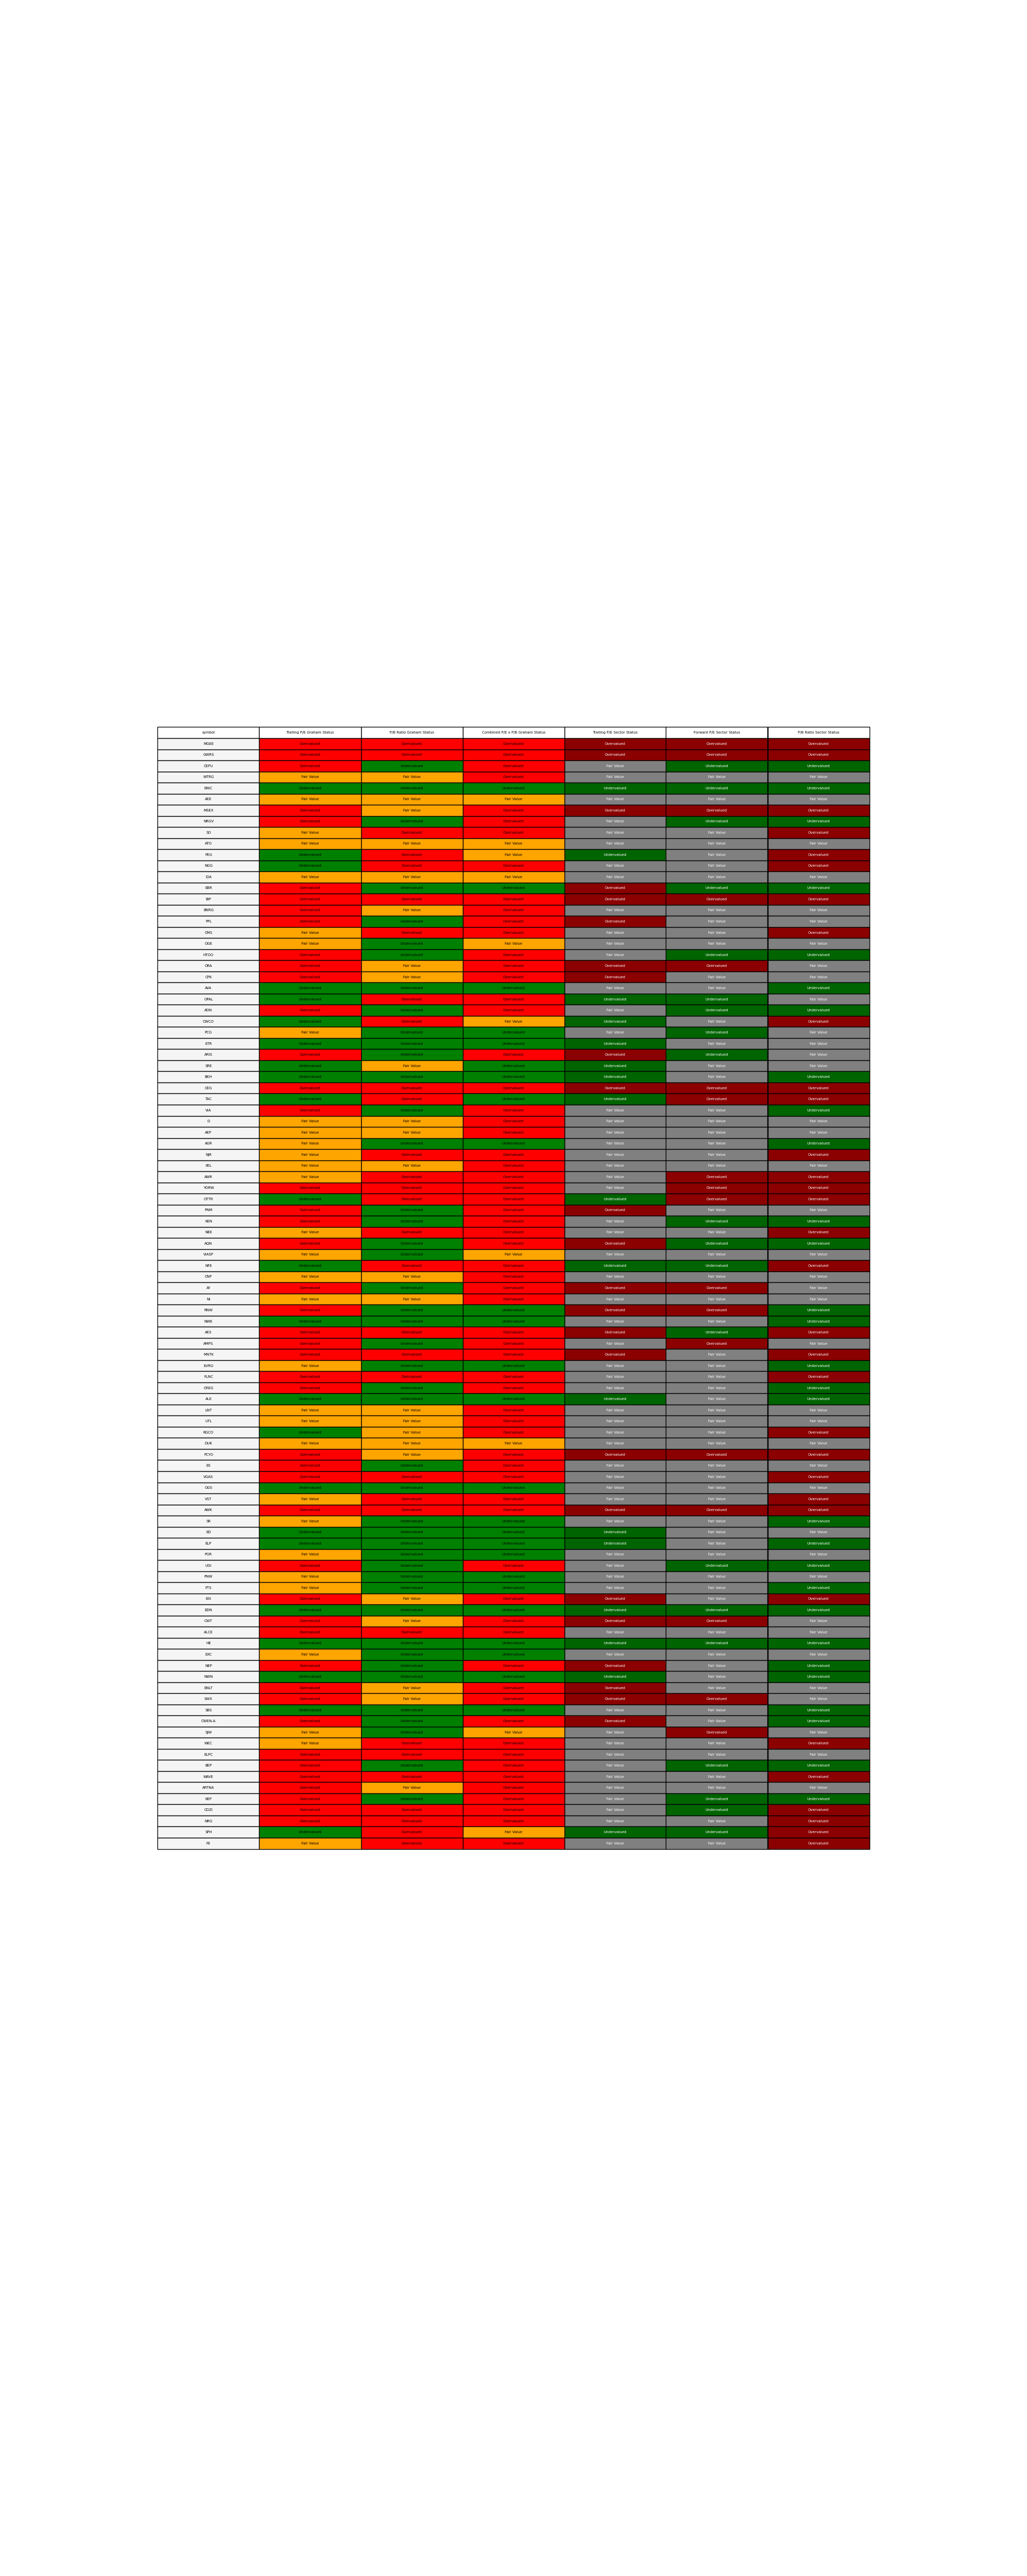

In [14]:
plot_sector_valuation_table(df_sector_results, 'Financial Services')

In [15]:
def plot_pe_ratios(df, sector_name):
    plt.figure(figsize=(14, 7))
    plt.title(f'P/E Ratios for {sector_name} Sector')
    plt.xlabel('Company Ticker')
    plt.ylabel('Trailing P/E Ratio')

    # Determine colors based on valuation status
    colors = df['Combined P/E x P/B Graham Status'].map({
        'Undervalued': 'green',
        'Fair Value': 'orange',
        'Overvalued': 'red',
        'N/A': 'gray'
    })

    # Plot each company's P/E ratio
    plt.scatter(df['Ticker'], df['Trailing P/E'], color=colors, alpha=0.7, s=100)

    # Optional: Add sector median P/E ratio line
    sector_median_pe = df['Trailing P/E'].median()
    plt.axhline(y=sector_median_pe, color='blue', linestyle='--', label=f'Sector Median P/E: {sector_median_pe:.2f}')

    plt.xticks(rotation=90)  # Rotate company tickers for better readability
    plt.legend()
    plt.tight_layout()
    plt.show()

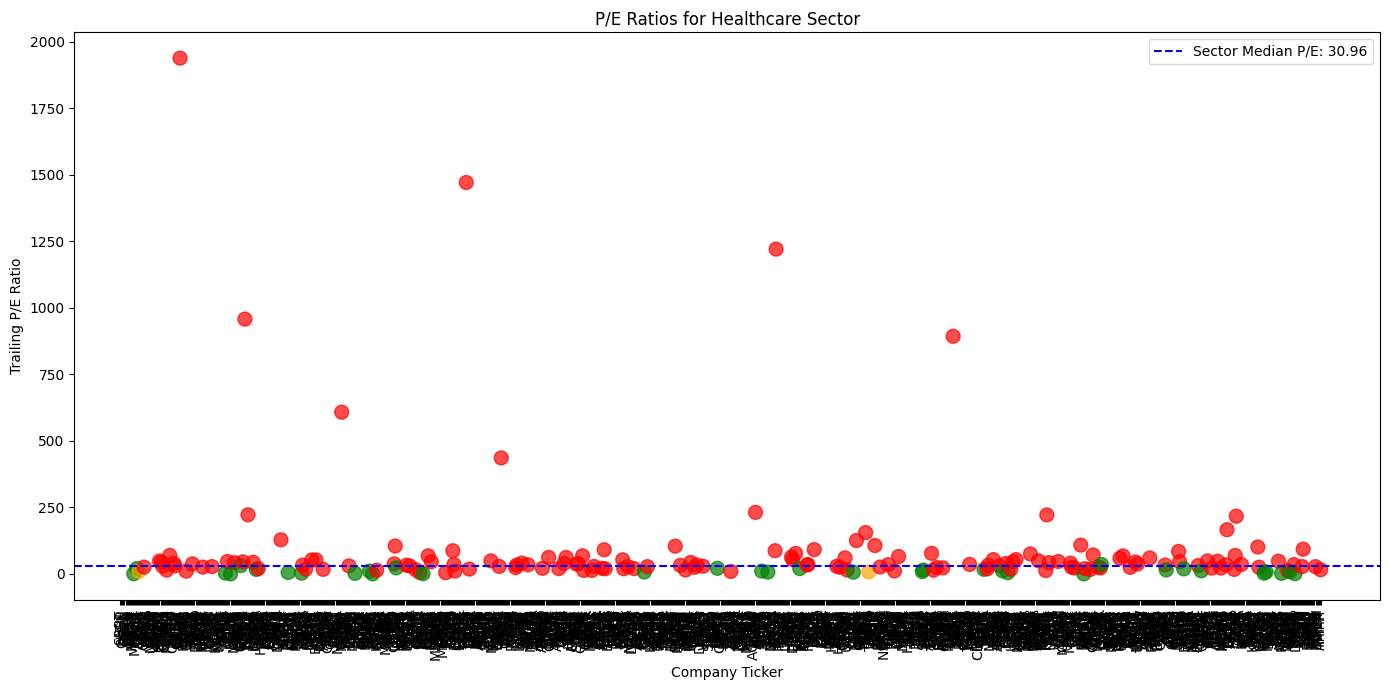

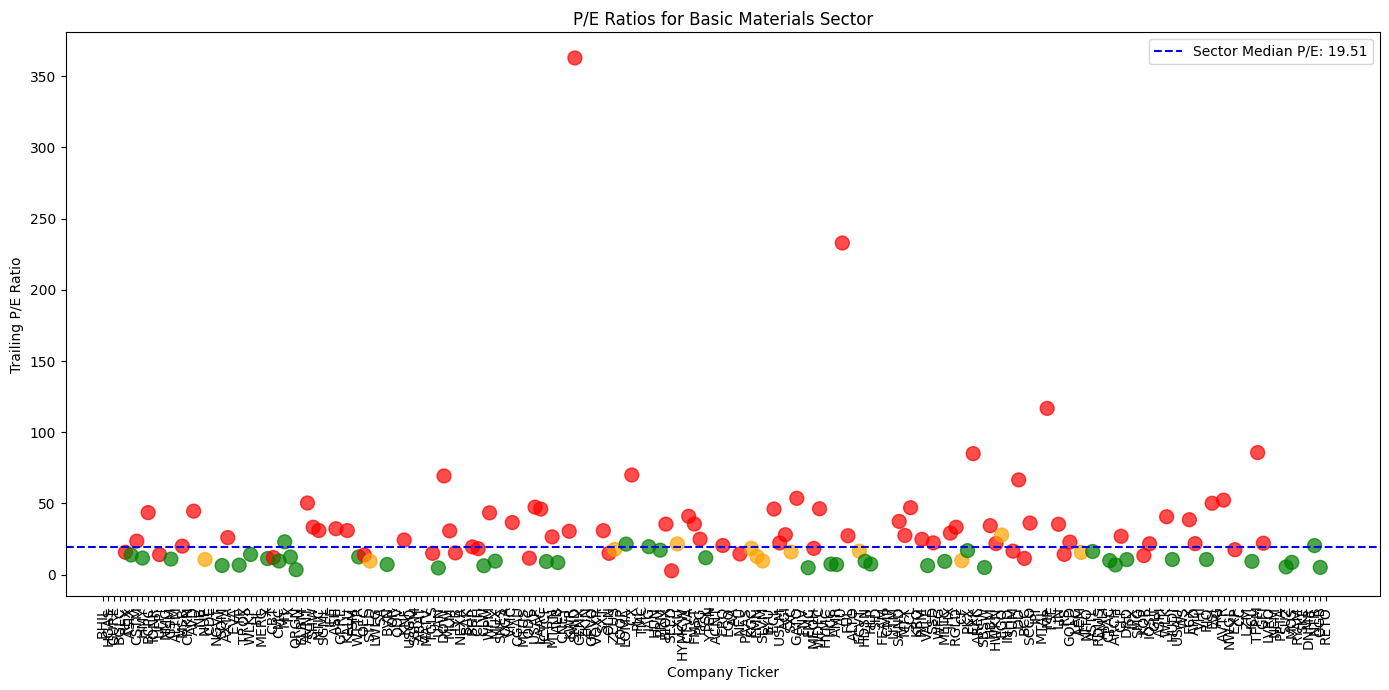

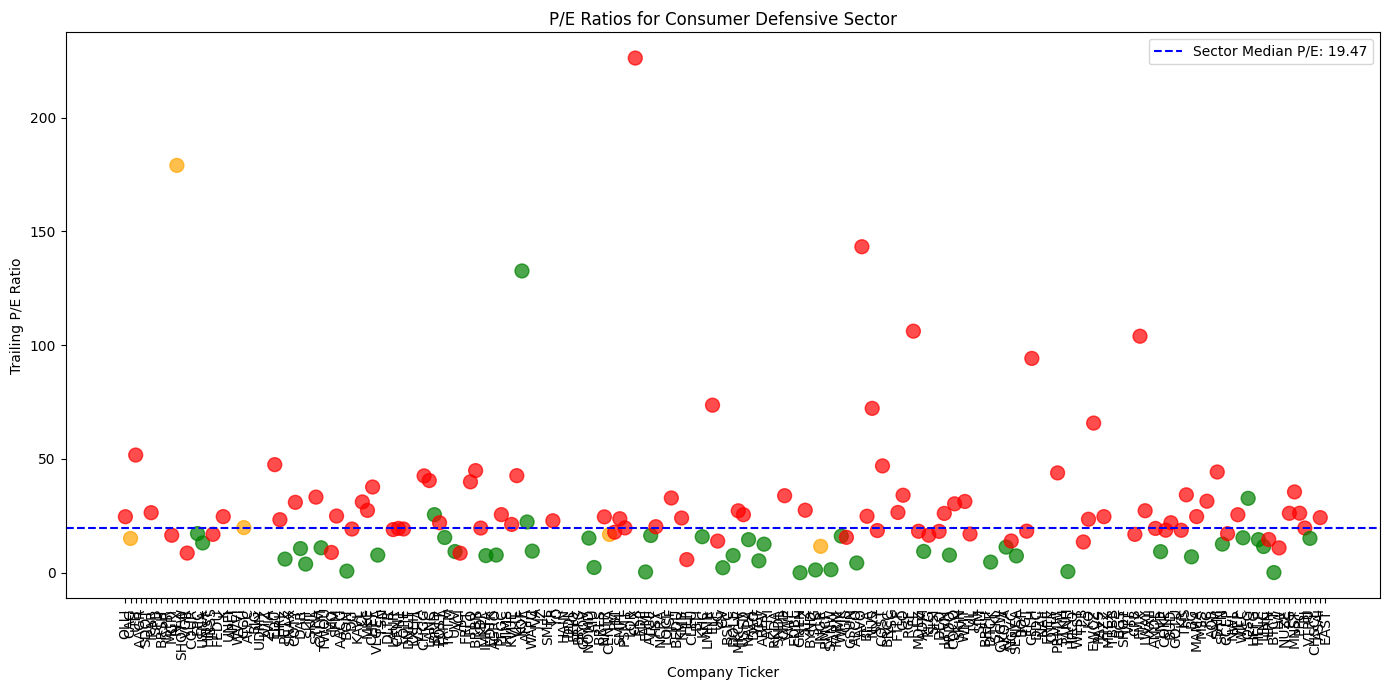

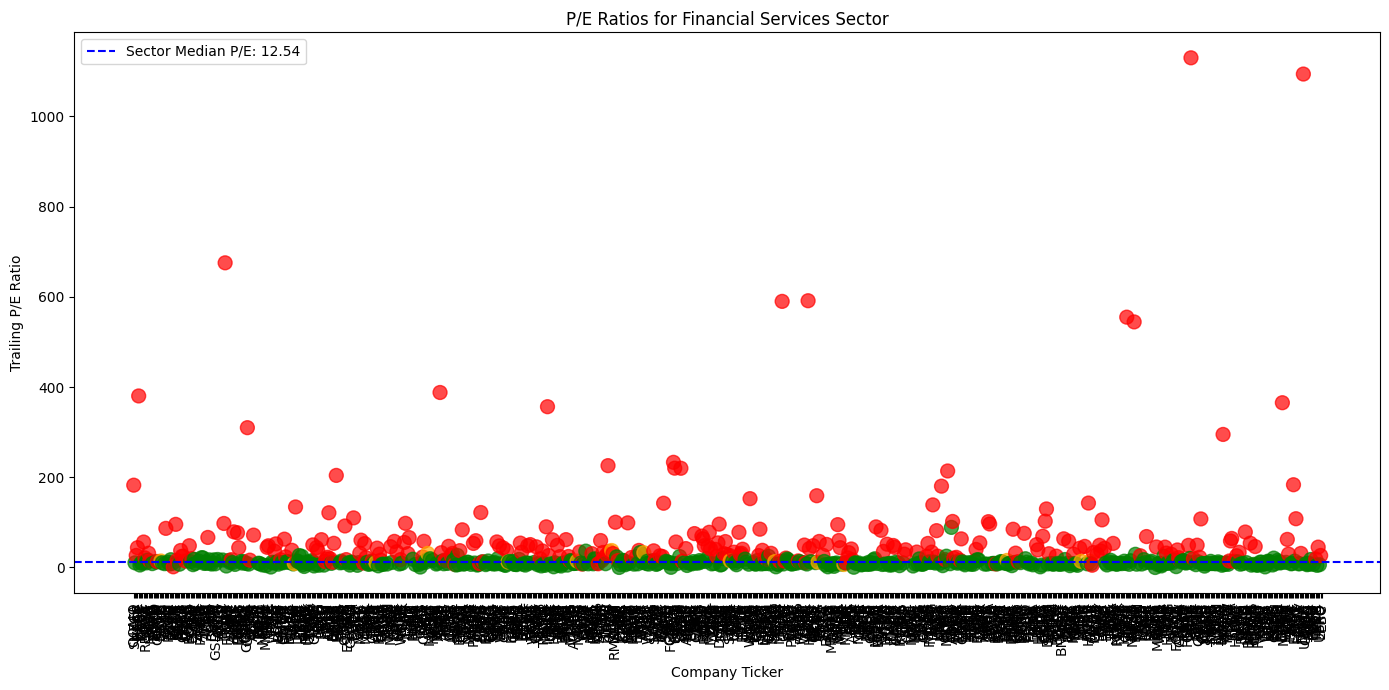

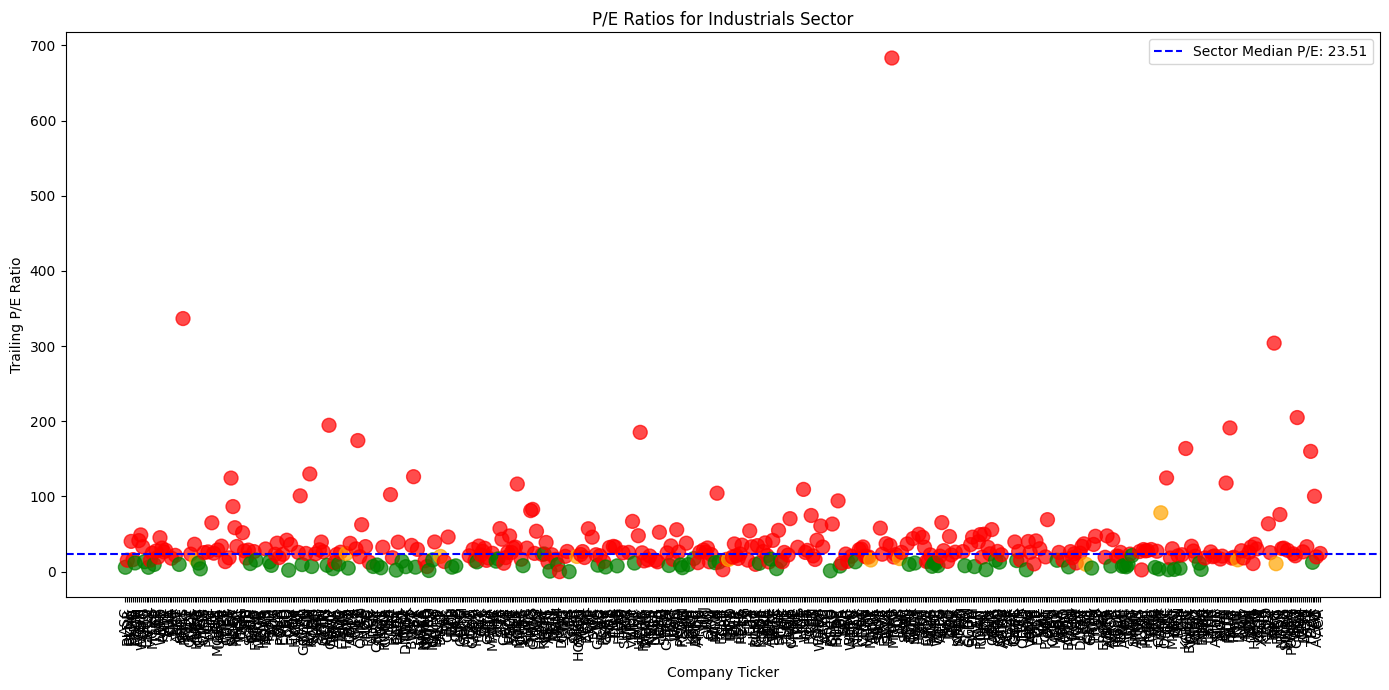

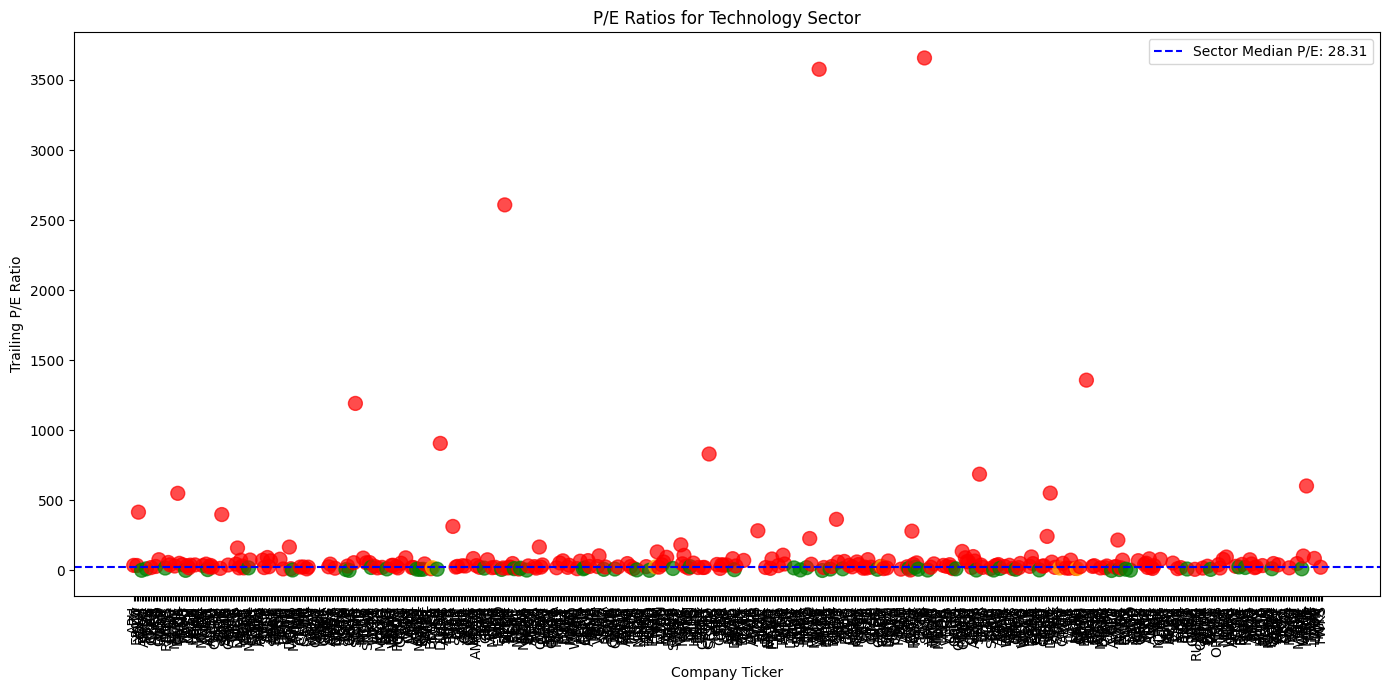

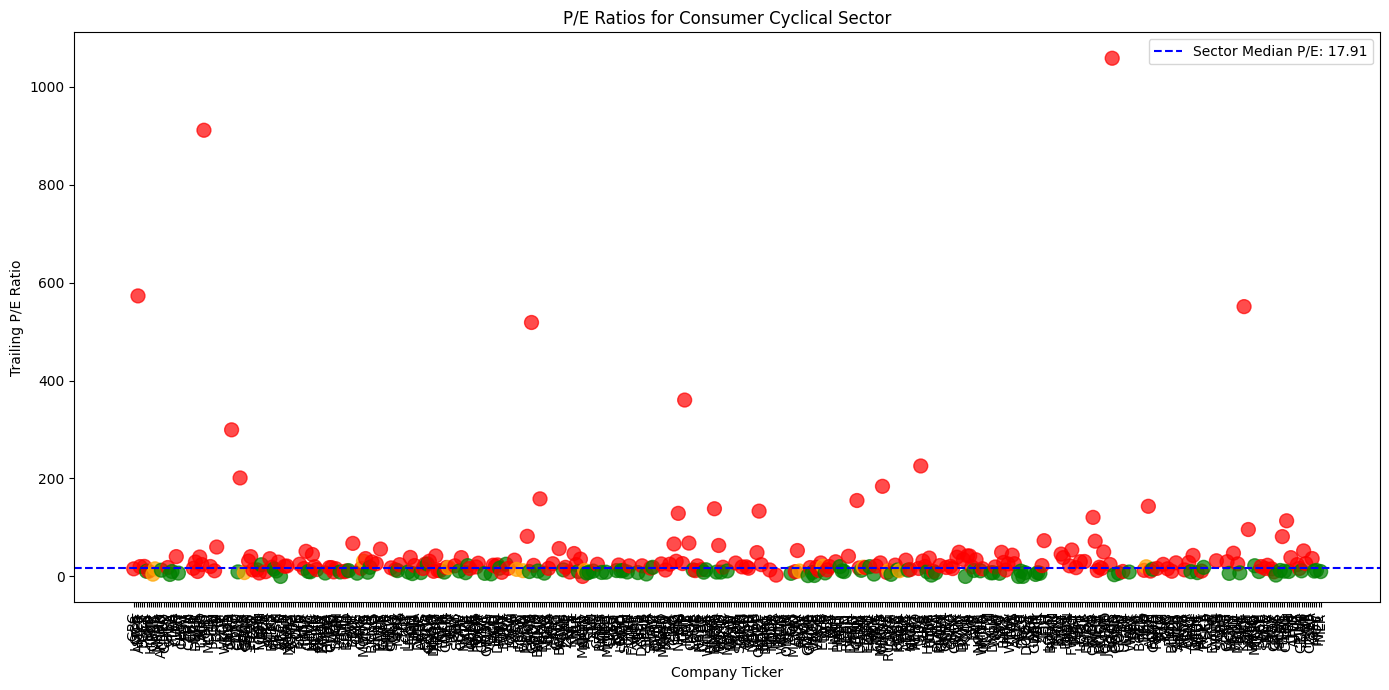

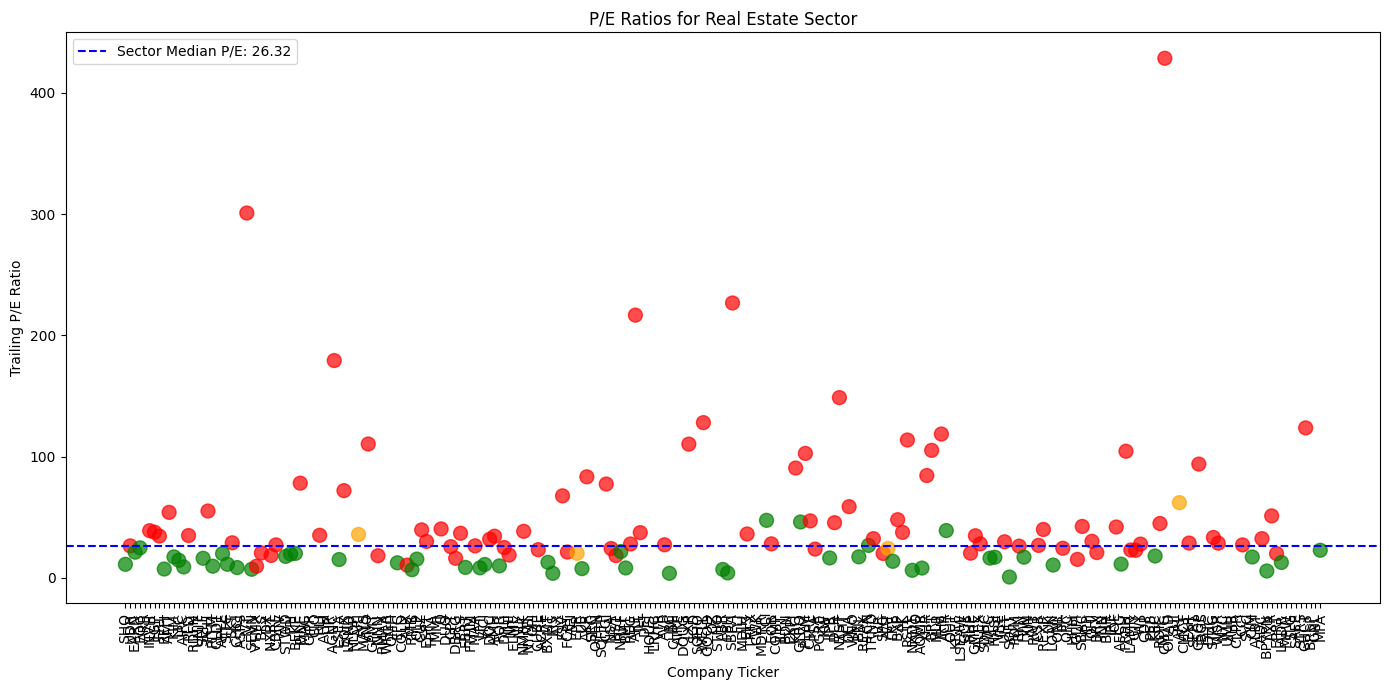

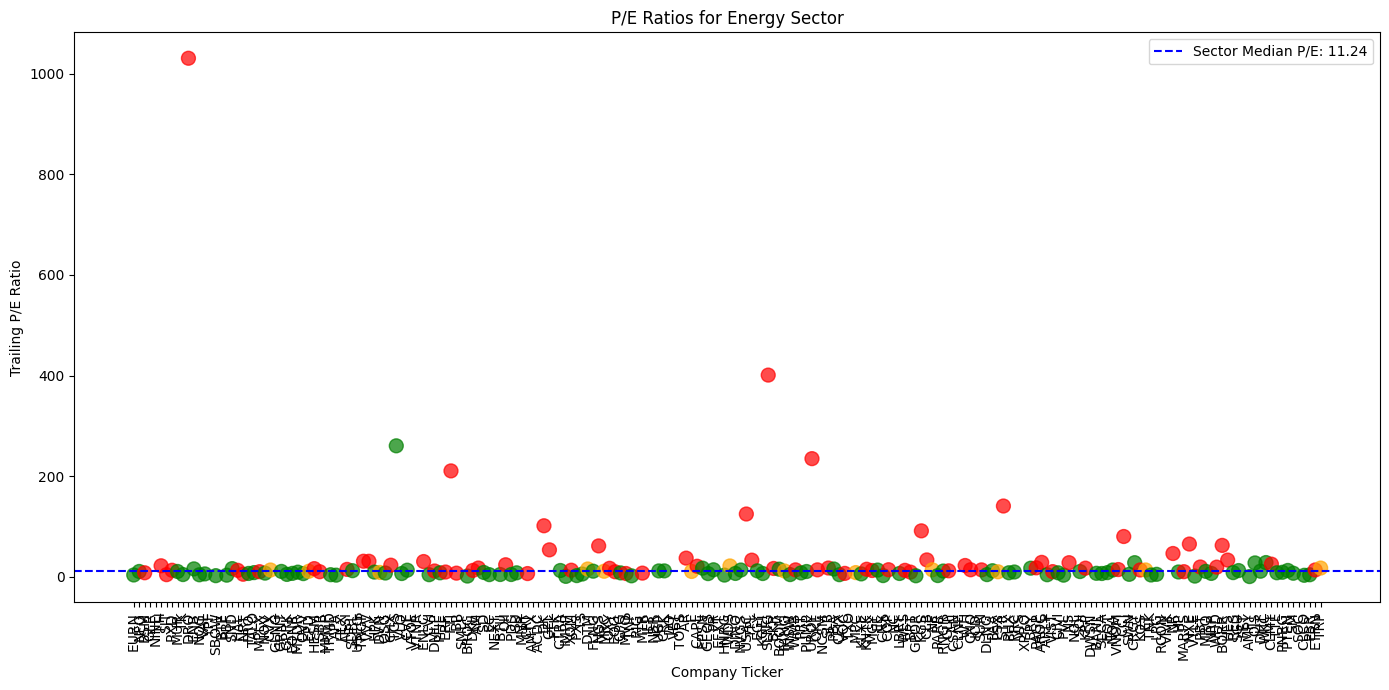

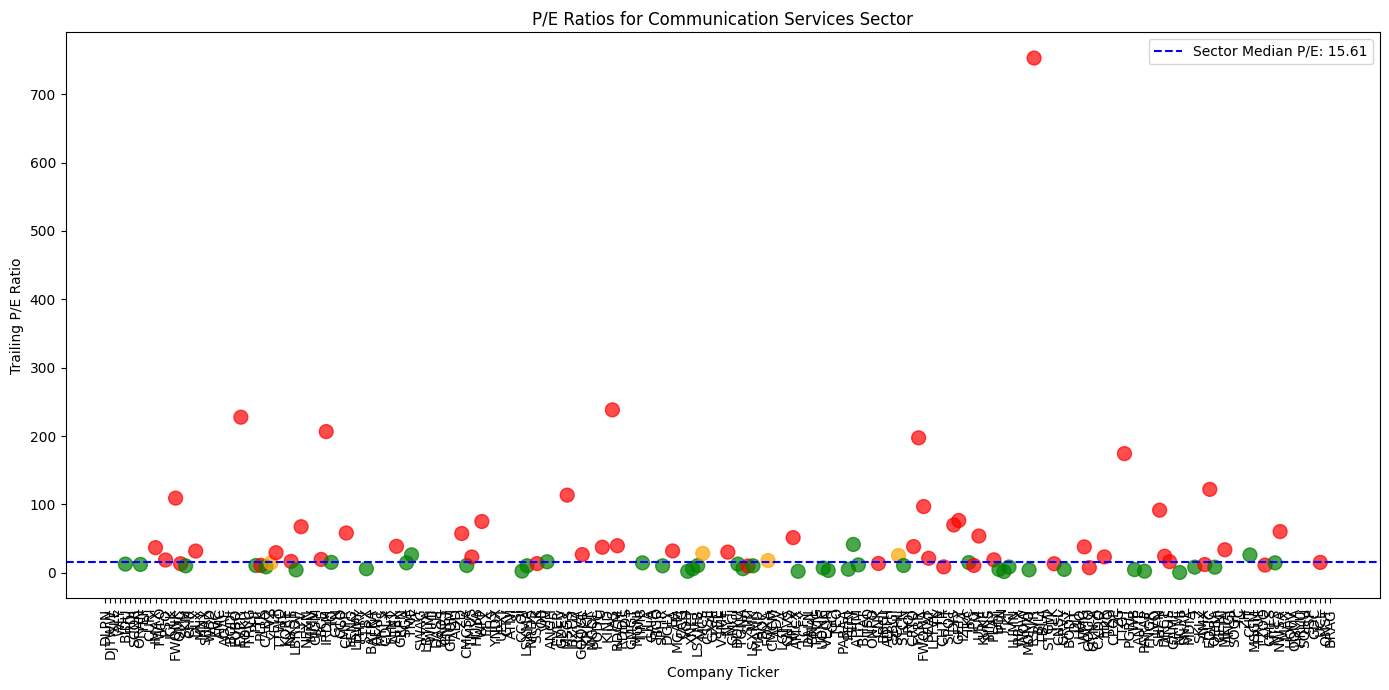

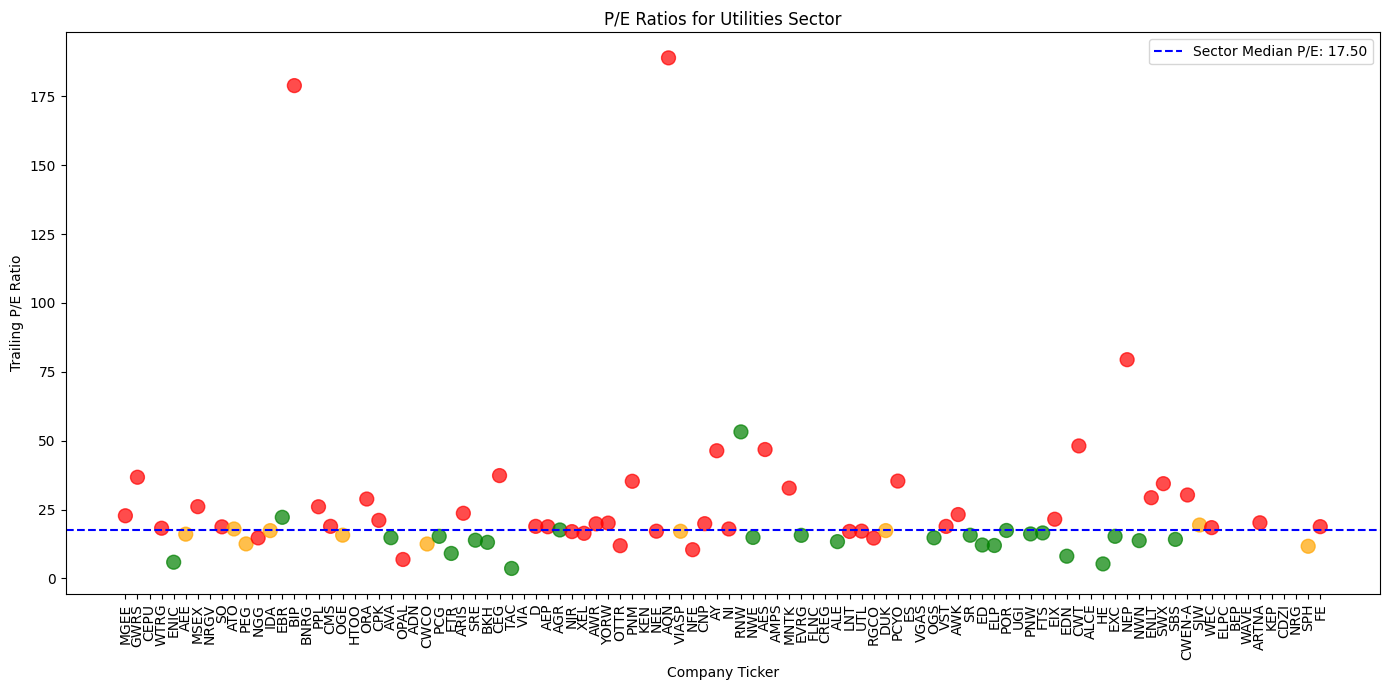

In [16]:
for sector in unique_sectors:
    df_sector_results = sector_results.get(sector, pd.DataFrame())
    plot_pe_ratios(df_sector_results, sector)

In [17]:
import numpy as np

def plot_pe_pb_with_marketcap(df):
    # Ensure Market Cap is in a suitable scale (e.g., billions) and convert to a size for the plot
    df['MarketCap_Billions'] = df['Market Cap'] / 1e9
    sizes = df['MarketCap_Billions'] * 10  # Scale market cap sizes for visibility

    # Create the scatter plot
    plt.figure(figsize=(14, 8))
    plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')
    
    # Loop through the DataFrame and add ticker symbols as text labels for each bubble
    for i, row in df.iterrows():
        # Check if both PB_Ratio and Trailing P/E are finite numbers
        if np.isfinite(row['P/B Ratio']) and np.isfinite(row['Trailing P/E']):
            plt.text(row['P/B Ratio'], row['Trailing P/E'], row['Ticker'], 
                     ha='center', va='center', fontsize=8, color='black', alpha=0.7)
    
    plt.title('P/B Ratio vs. Trailing P/E with Market Cap Size Indicator')
    plt.xlabel('P/B Ratio')
    plt.ylabel('Trailing P/E Ratio')
    plt.xscale('log')  # Using log scale for P/B Ratio if wide range values are expected
    plt.yscale('log')  # Using log scale for P/E Ratio to handle wide range of values and outliers

    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [18]:
'''
******
Use this if you want to plot all the data in one figure, but it gets quite messy
******

# Initialize an empty DataFrame
all_sectors_df = pd.DataFrame()

for sector, df in sector_results_dict.items():
    # Optionally, add a sector column to each sector's DataFrame before concatenation
    df['Sector'] = sector
    # Concatenate the current sector's DataFrame to the comprehensive DataFrame
    all_sectors_df = pd.concat([all_sectors_df, df], ignore_index=True)
'''

"\n******\nUse this if you want to plot all the data in one figure, but it gets quite messy\n******\n\n# Initialize an empty DataFrame\nall_sectors_df = pd.DataFrame()\n\nfor sector, df in sector_results_dict.items():\n    # Optionally, add a sector column to each sector's DataFrame before concatenation\n    df['Sector'] = sector\n    # Concatenate the current sector's DataFrame to the comprehensive DataFrame\n    all_sectors_df = pd.concat([all_sectors_df, df], ignore_index=True)\n"

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_12464/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


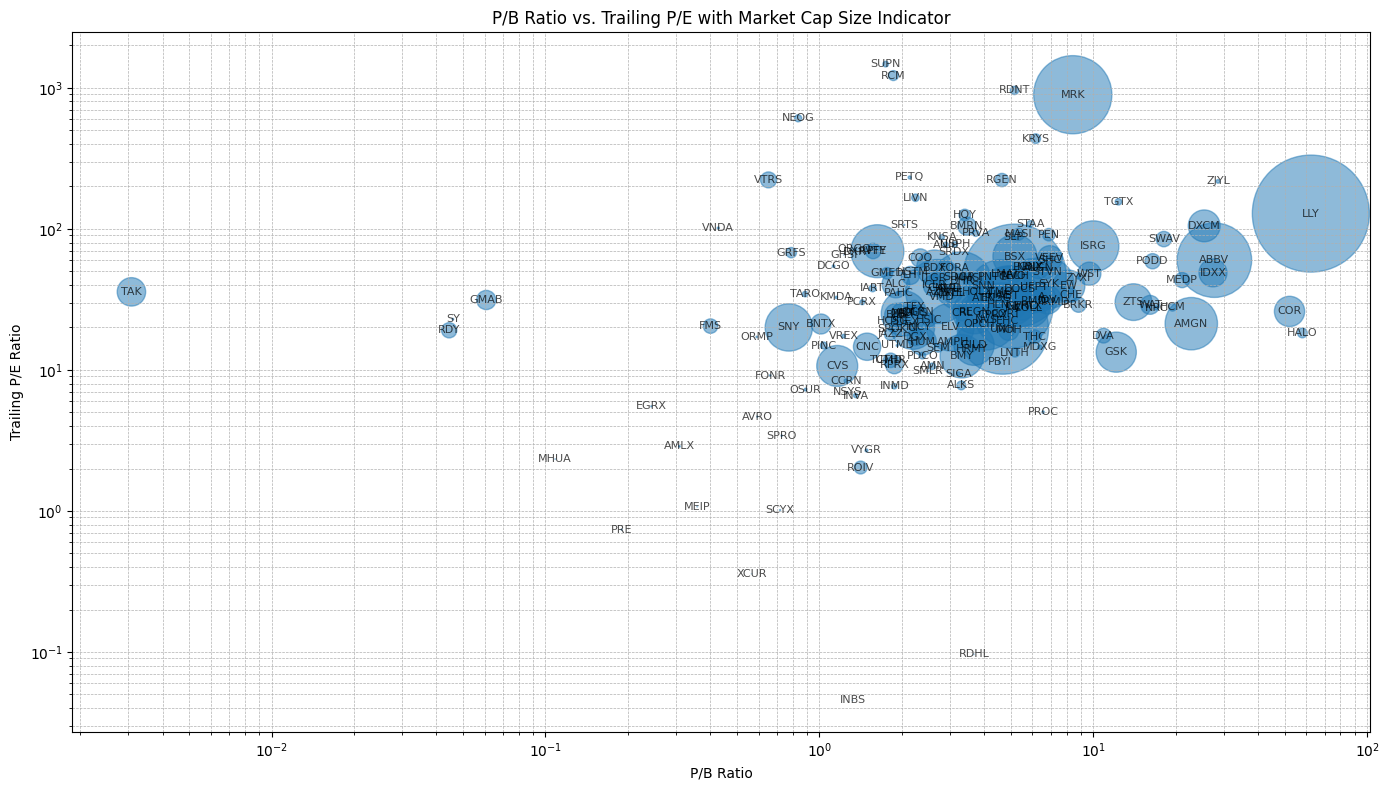

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_12464/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


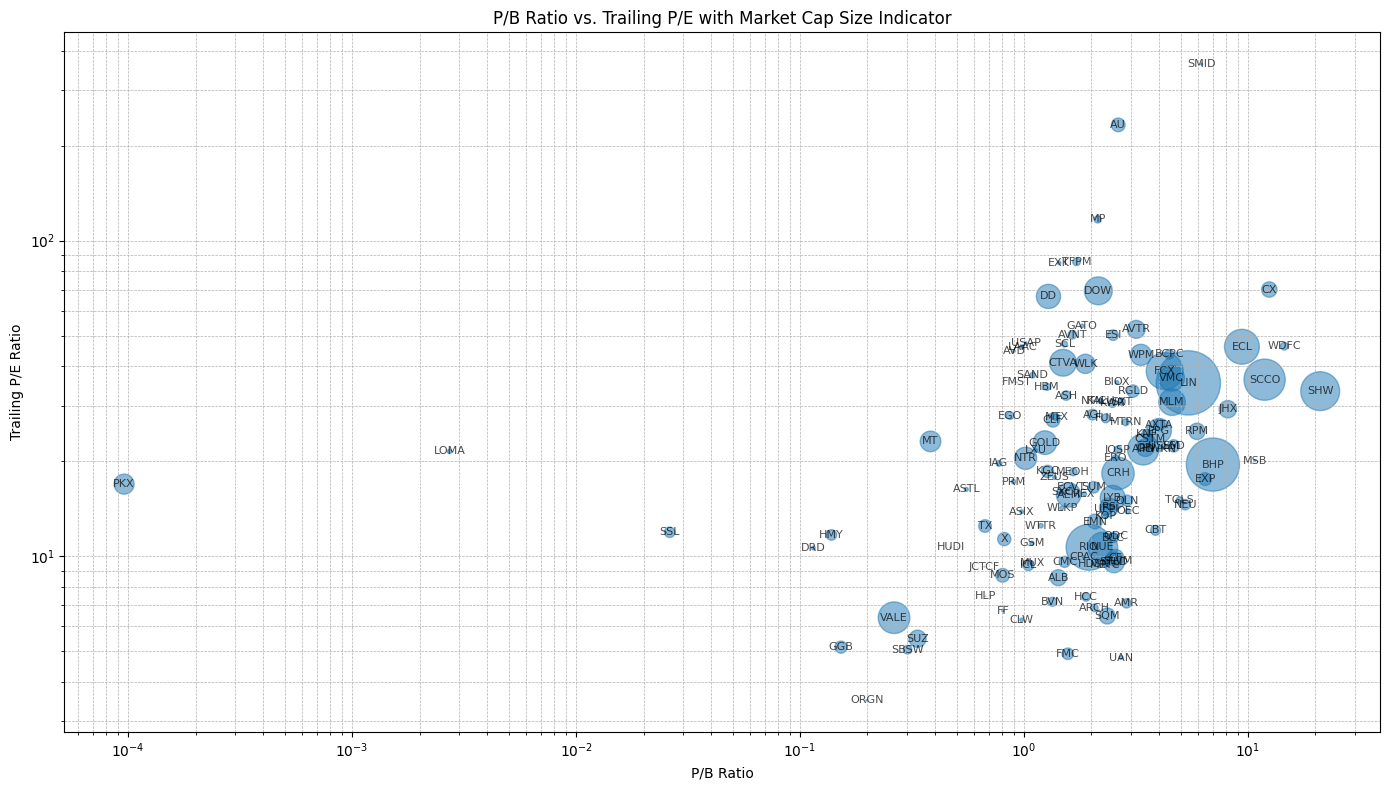

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_12464/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


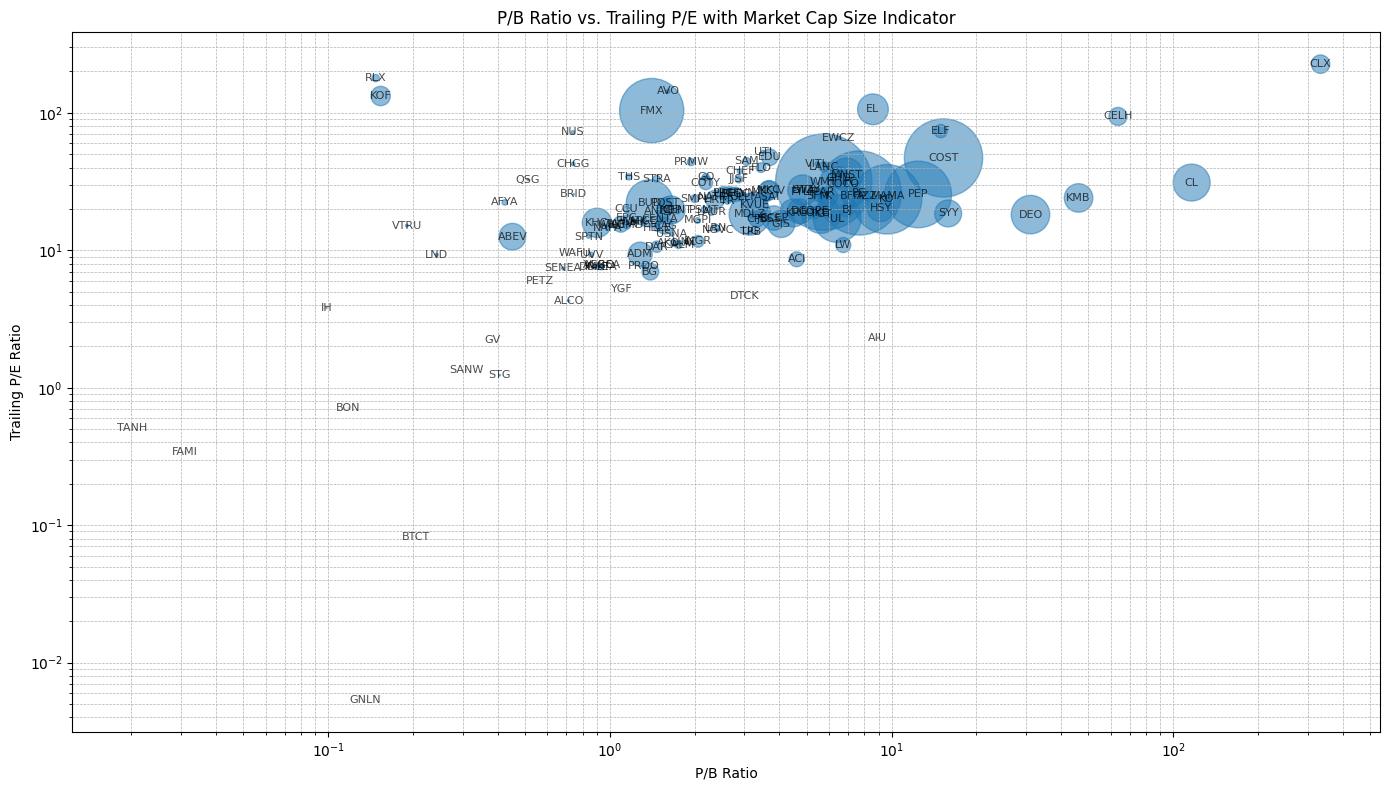

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_12464/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


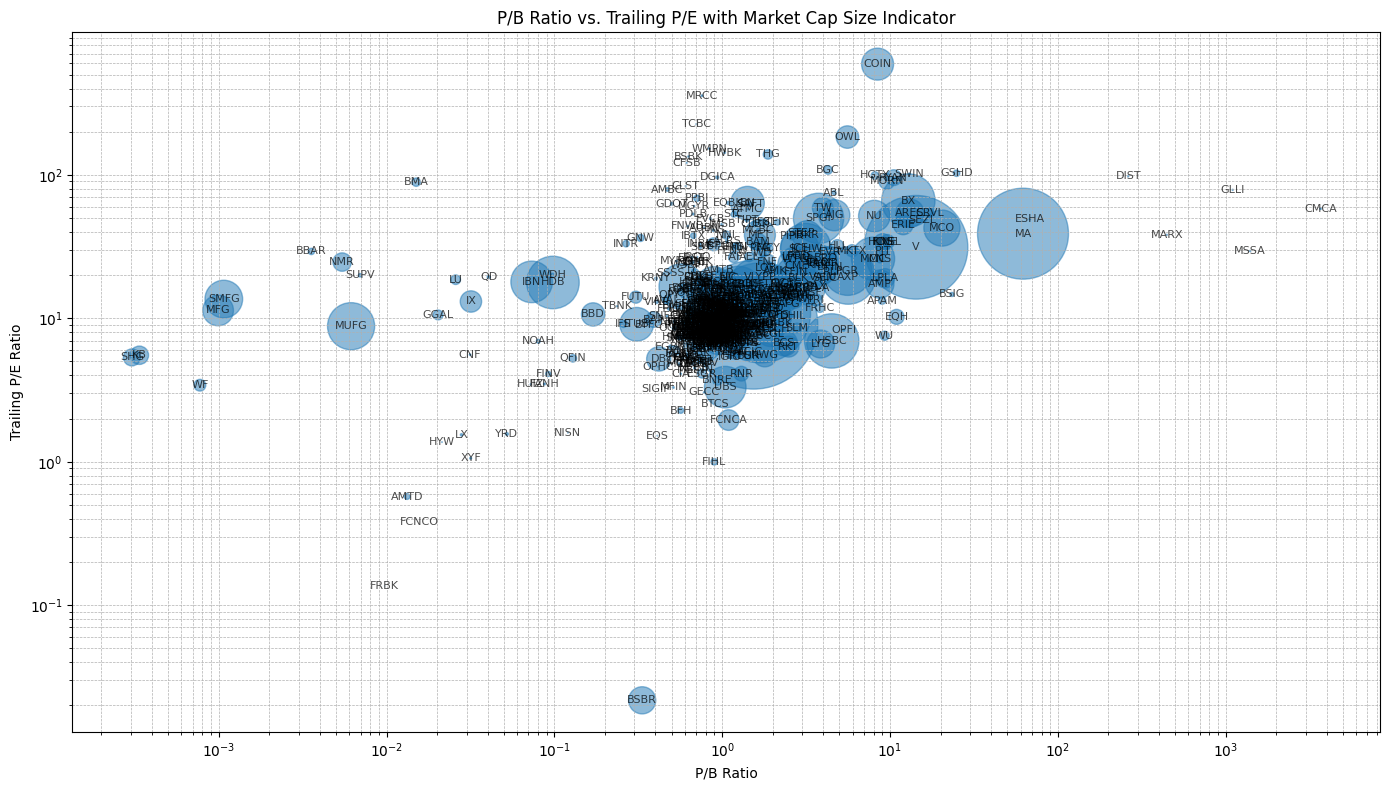

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_12464/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


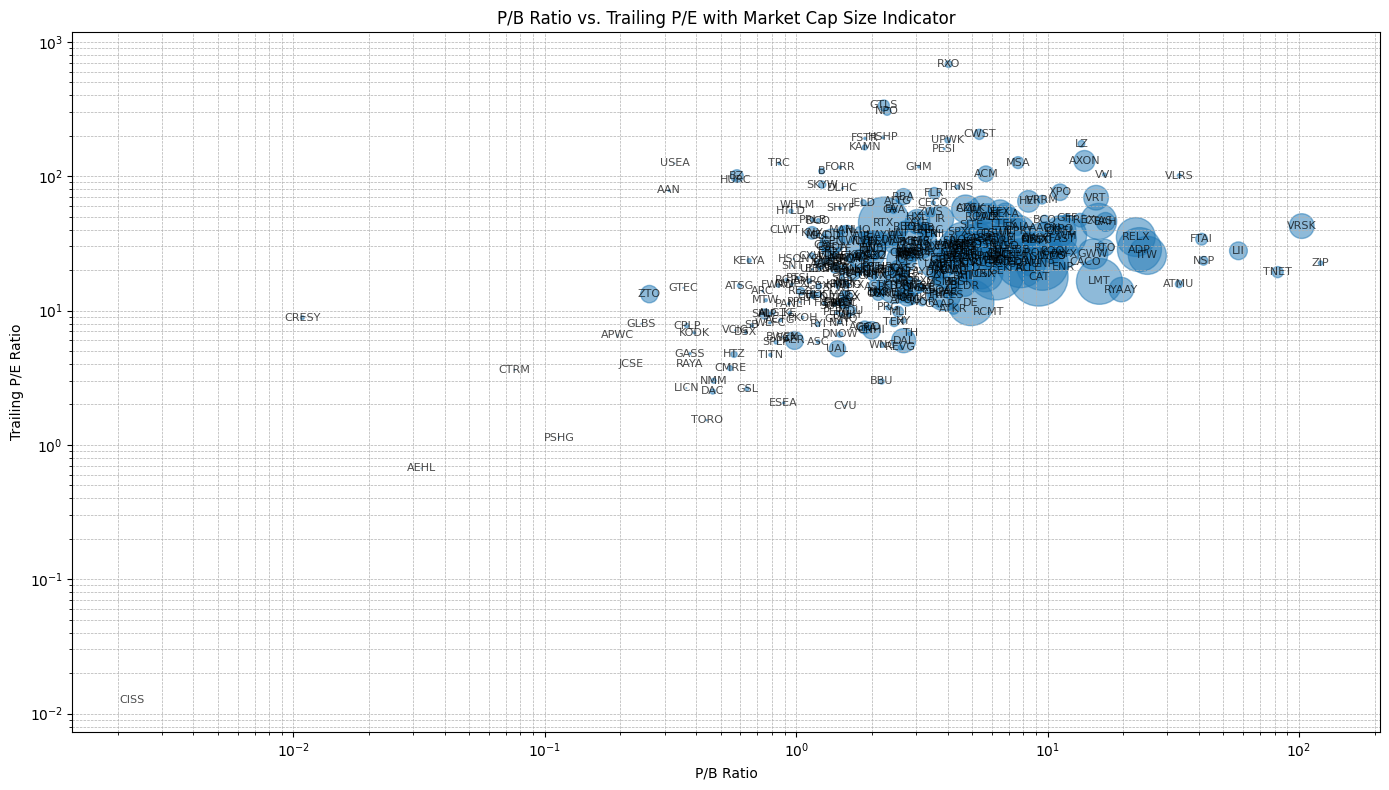

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_12464/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


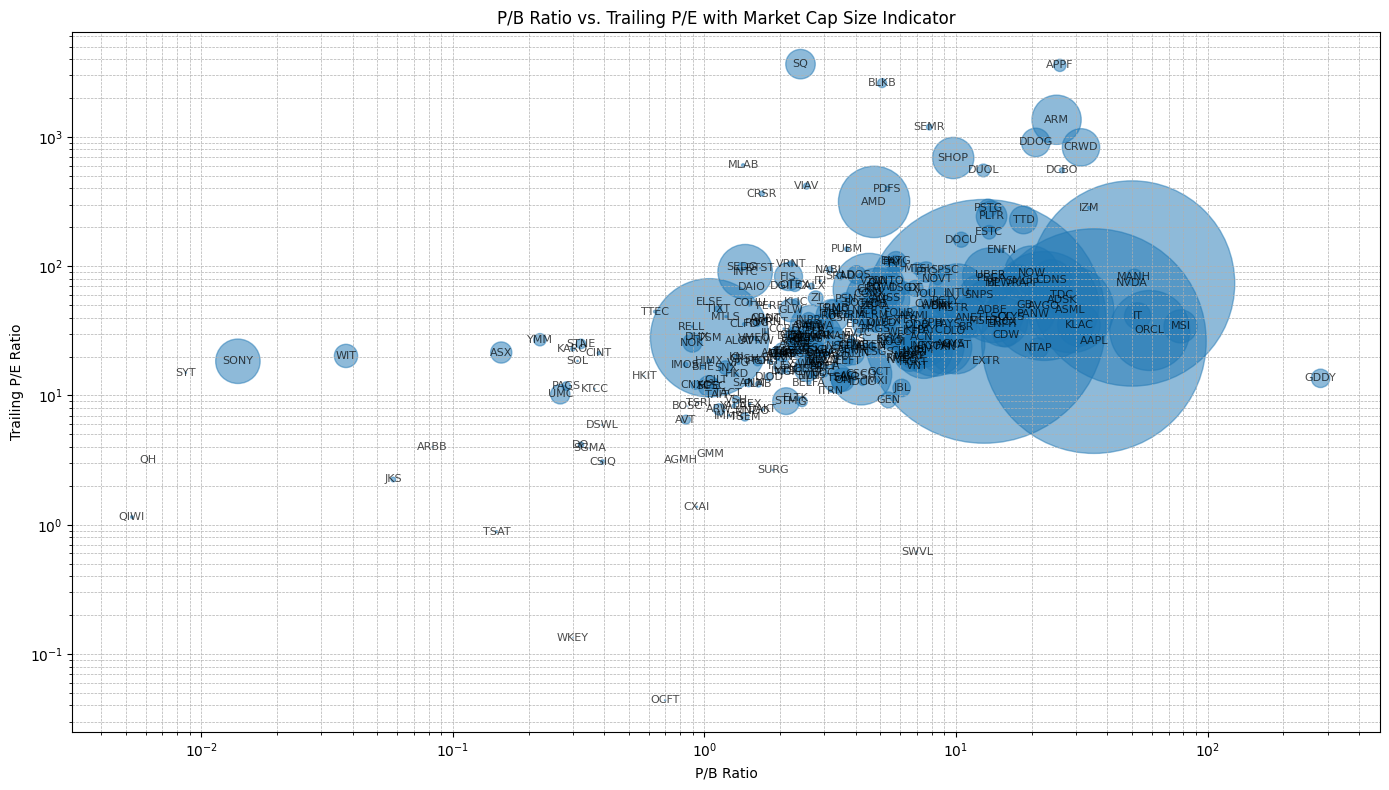

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_12464/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


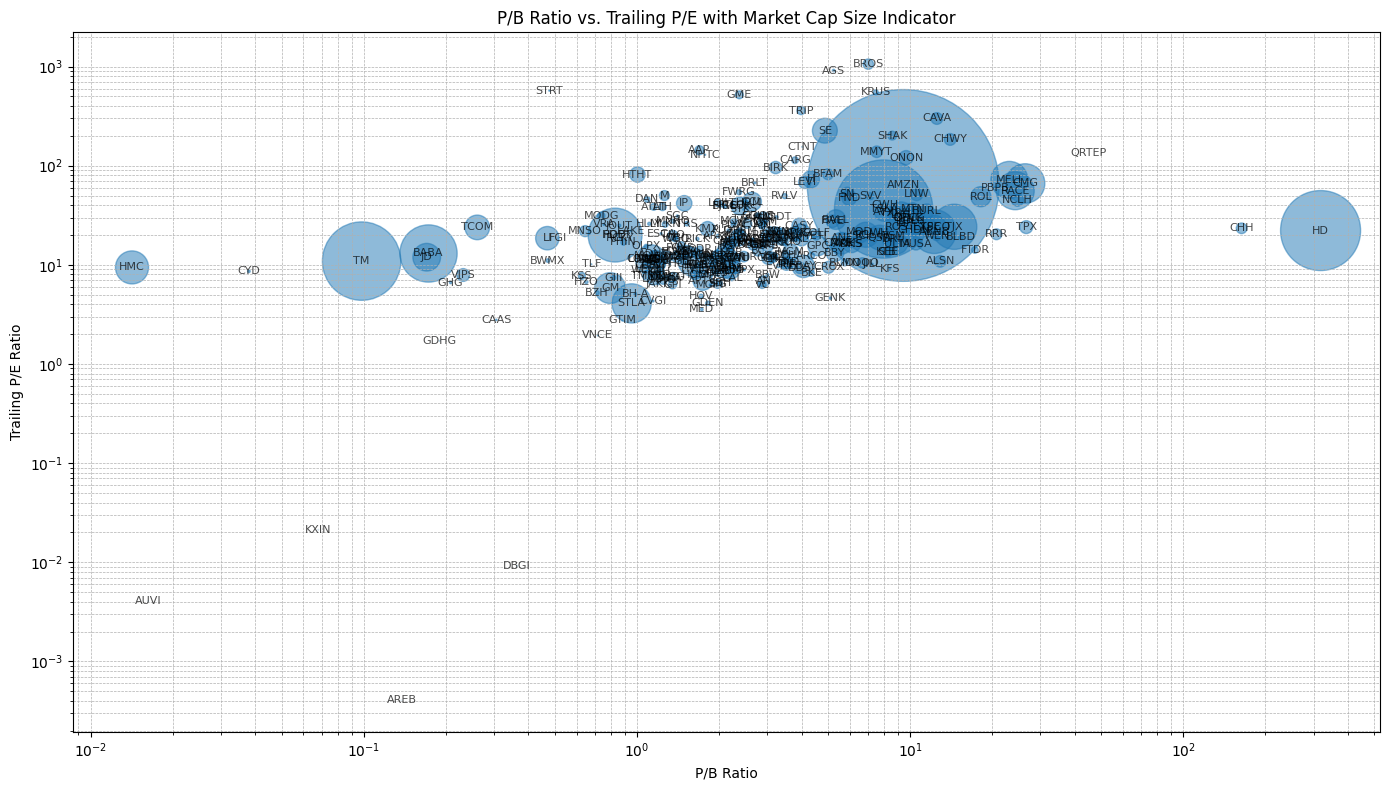

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_12464/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


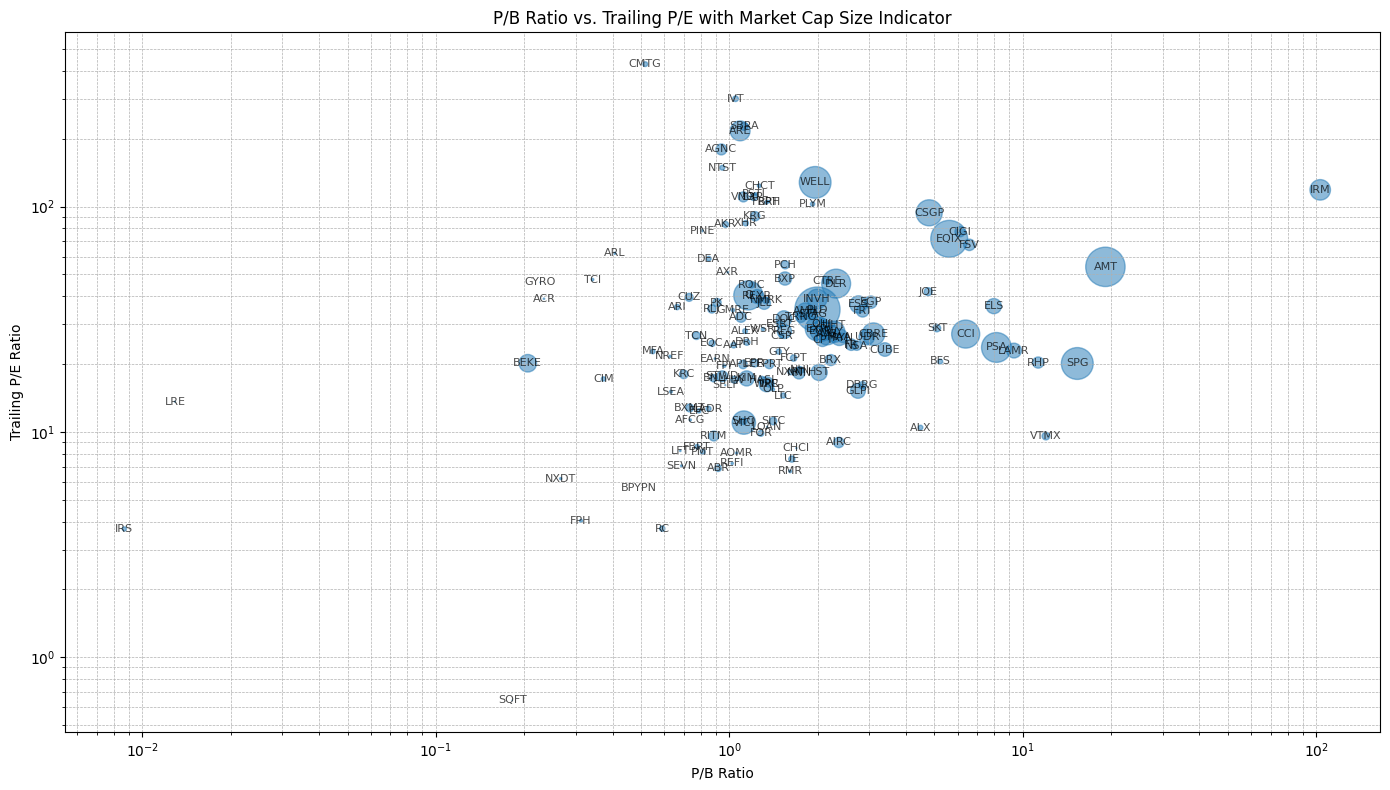

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_12464/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


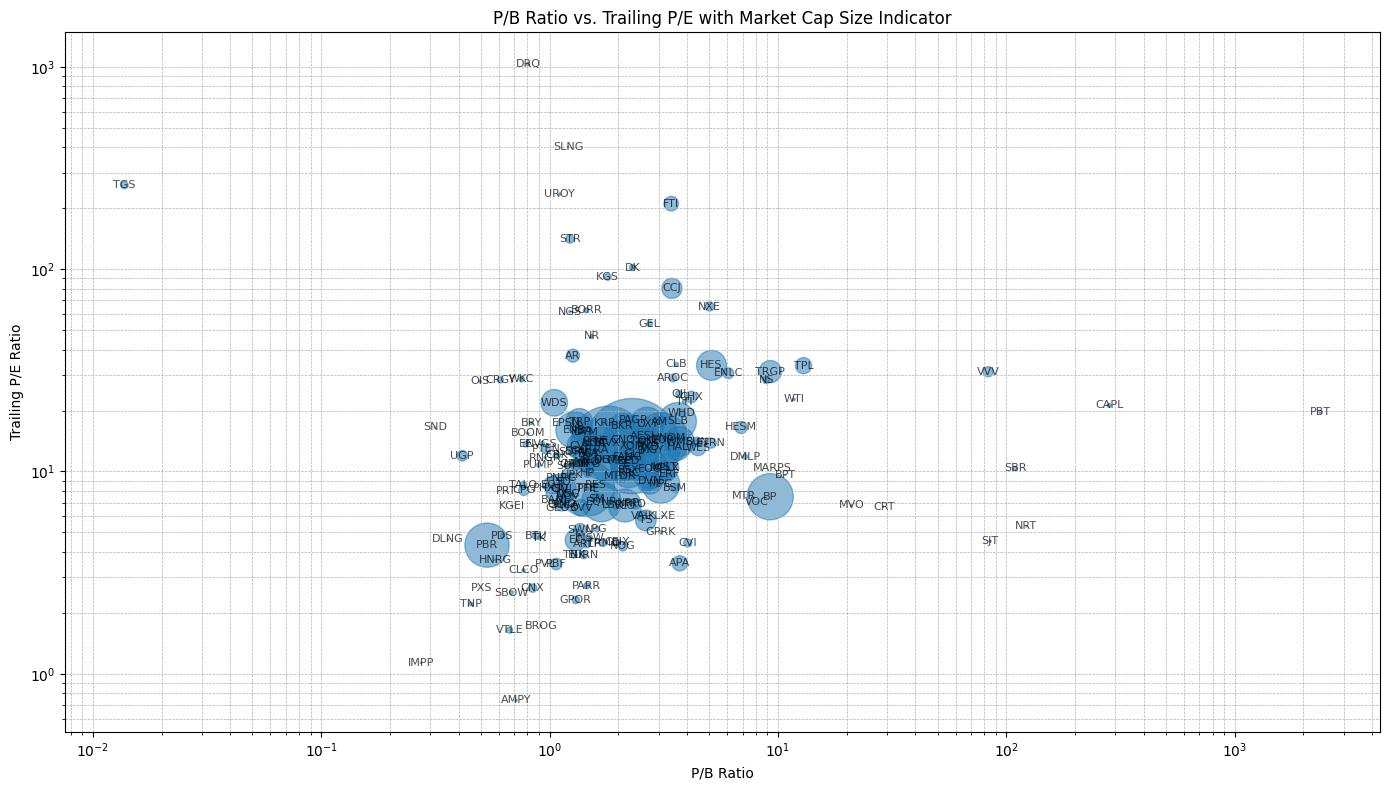

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_12464/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


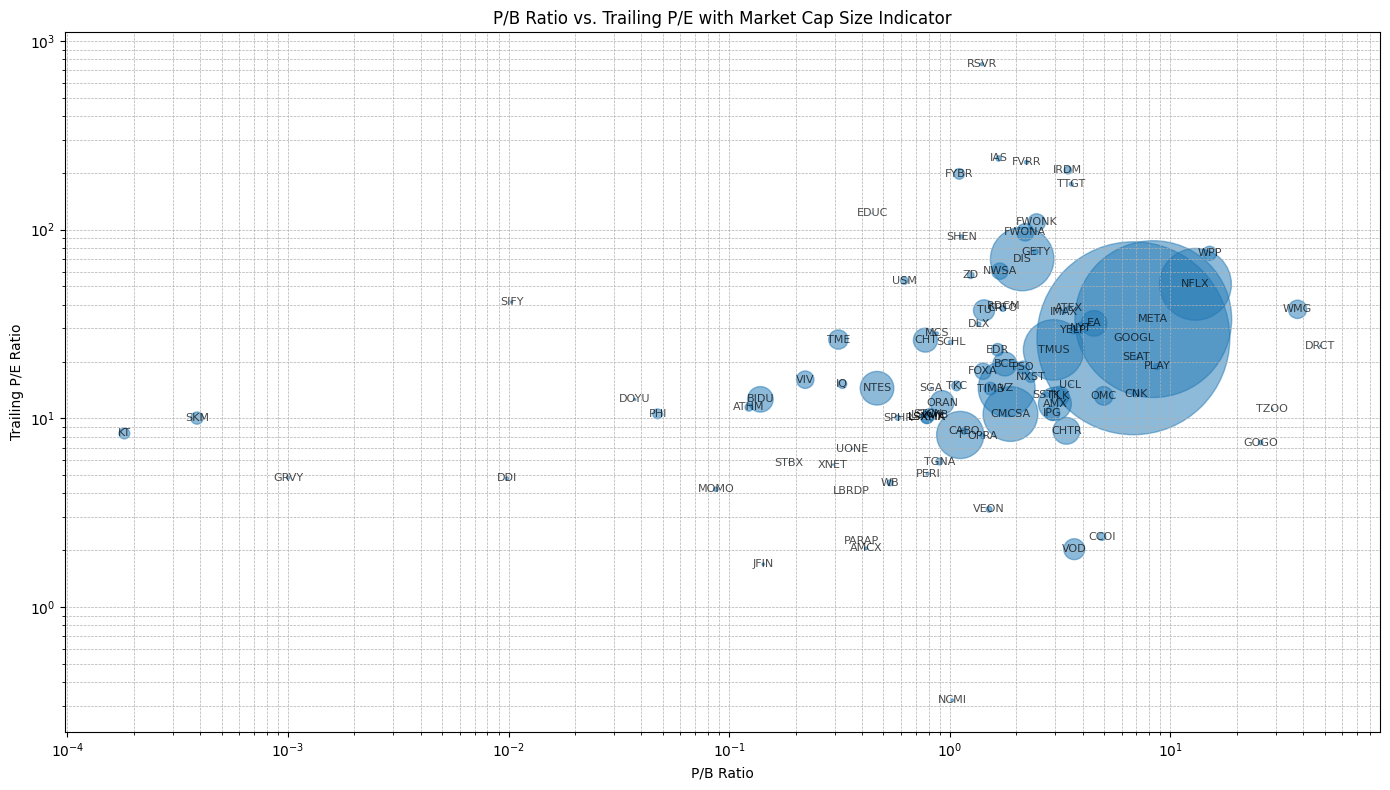

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_12464/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


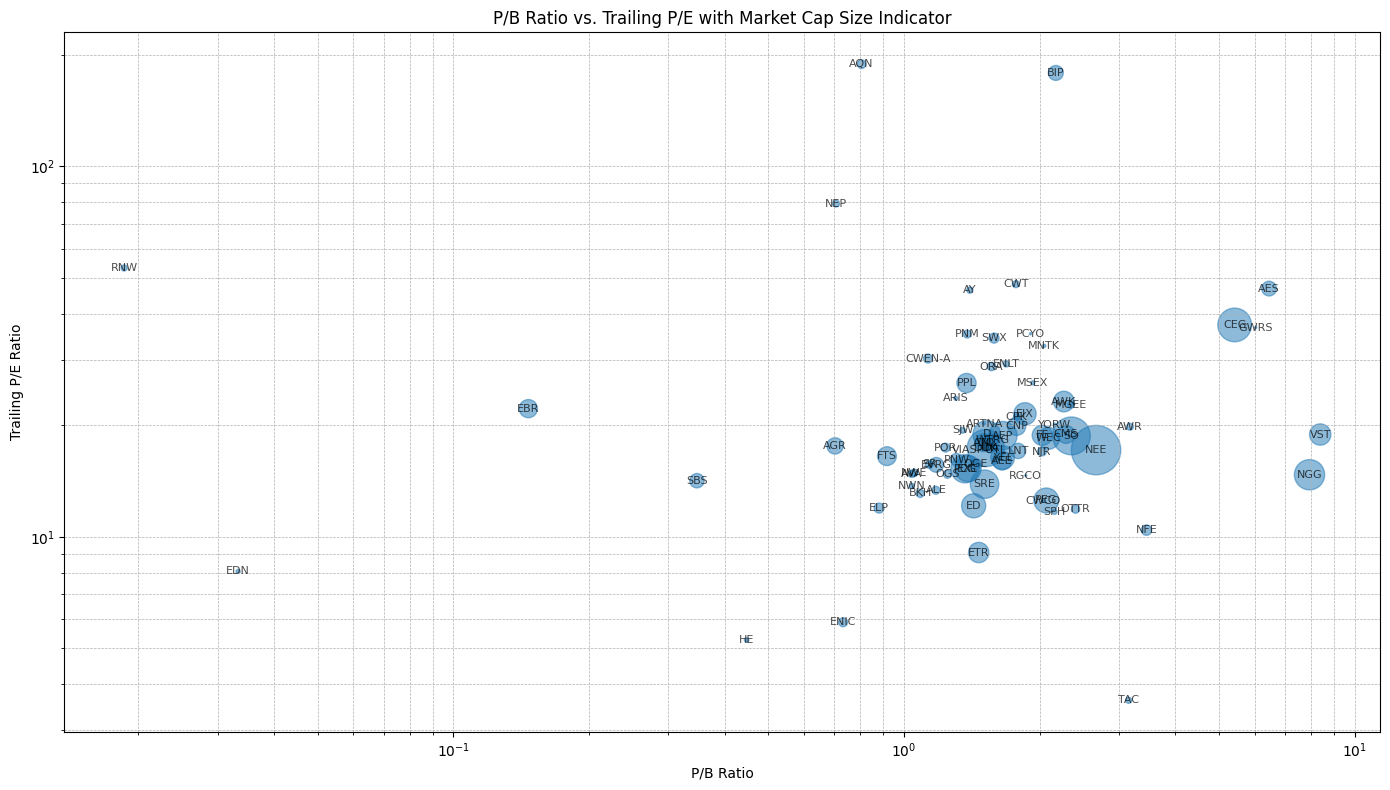

In [19]:
for sector in unique_sectors:
    plot_pe_pb_with_marketcap(sector_results[sector])